### WordVec Embedding을 활용한 책 추천 알고리즘

#### 문서를 고정된 길이의 벡터로 변환해 벡터vs벡터로 문서 비교
---
- 문서를 벡터화하는 DocVec, Sent2Vec이 있지만,
- 단어 벡터를 구하고 문서에 존해하는 단어벡터의 평균을 문서 벡터로 간주할 수 있음
- 단어 벡터의 평균으로 선호하는 도서와 유사한 도서를 찾아주는 방식!

#### 1. 데이터 로드 및 전처리

In [19]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  2382 non-null   int64  
 1   Desc          2382 non-null   object 
 2   Unnamed: 0    1185 non-null   float64
 3   author        2382 non-null   object 
 4   genre         2382 non-null   object 
 5   image_link    2382 non-null   object 
 6   rating        2382 non-null   float64
 7   title         2382 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 149.0+ KB


In [22]:
df.head(4)

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing


In [23]:
df.drop(['Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=True)

In [24]:
df.head(4)

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing


In [25]:
df['genre'].value_counts()

Non-Fiction    1197
Business       1185
Name: genre, dtype: int64

In [10]:
# 에러 메시지 나와서 nltk 라이브러리 설치
# !pip install nltk

In [26]:
## 에러 나와서 설치하고 추가 확인

import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# 불용어 및 소문자 변환, 정규식으로 html 양식, 구두점 제거

from nltk.corpus import stopwords

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [28]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [29]:
df.isnull().sum()

Desc          0
author        0
genre         0
image_link    0
rating        0
title         0
cleaned       0
dtype: int64

In [30]:
# 빈 값이 있는 행을 nan으로 변환 후 제거

df['cleaned'].replace("", np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수: ', len(df))

전체 문서의 수:  2381


In [31]:
df.tail()

,Desc,author,genre,image_link,rating,title,cleaned
2377,"Ralph Roberts, a sus setenta años y tras la mu...",Stephen King,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,3.82,Insomnia,ralph roberts sus setenta aos tras la muerte d...
2378,Murder at the Vicarage marks the debut of Agat...,Agatha Christie,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Murder at the Vicarage,murder vicarage marks debut agatha christies u...
2379,In 1951 John Wyndham published his novel The D...,John Wyndham,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.02,The Day of the Triffids,john wyndham published novel day triffids mode...
2380,This now classic book revealed Flannery O'Conn...,Flannery O'Connor,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.22,A Good Man is Hard to Find and Other Stories,classic book revealed flannery o connor one or...
2381,Imbued on every page with Frank McCourt's asto...,Frank McCourt,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.11,Angela's Ashes,imbued every page frank mccourt s astounding h...


In [32]:
# 토큰화하여 corpus라는 리스트에 저장

corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

corpus[:5]

[['know',
  'power',
  'shifting',
  'west',
  'east',
  'north',
  'south',
  'presidential',
  'palaces',
  'public',
  'squares',
  'formidable',
  'corporate',
  'behemoths',
  'nimble',
  'startups',
  'and',
  'slowly',
  'surely',
  'men',
  'women',
  'power',
  'merely',
  'shifting',
  'dispersing',
  'also',
  'decaying',
  'power',
  'today',
  'constrained',
  'risk',
  'losing',
  'ever',
  'before',
  'end',
  'power',
  'award',
  'winning',
  'columnist',
  'former',
  'foreign',
  'policy',
  'editor',
  'moiss',
  'nam',
  'illuminates',
  'struggle',
  'once',
  'dominant',
  'megaplayers',
  'new',
  'micropowers',
  'challenging',
  'every',
  'field',
  'human',
  'endeavor',
  'drawing',
  'provocative',
  'original',
  'research',
  'nam',
  'shows',
  'antiestablishment',
  'drive',
  'micropowers',
  'topple',
  'tyrants',
  'dislodge',
  'monopolies',
  'open',
  'remarkable',
  'new',
  'opportunities',
  'also',
  'lead',
  'chaos',
  'paralysis',
  'nam',

#### 2. 사전 훈련된 워드 임베딩 사용하기

In [49]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

word2vec_model = Word2Vec(vector_size=300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

In [50]:
word2vec_model

### word2vec model, Migrating to Gensim 4.0 모듈 변경
- [깃허브 설명 참고]("https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4")

In [59]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.key_to_index:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [60]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 2381


#### 3. 추천 시스템 구현

- 각 문서 벡터 간 코사인 유사도를 구하기

In [61]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 matrix 크기: ', cosine_similarities.shape)

코사인 유사도 matrix 크기:  (2381, 2381)


- 책을 선택하면, 코사인 유사도를 이용해 가장 줄거리가 유사한 5개의 책을 찾아보자

In [87]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
#     print(sim_scores)
    
    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
#         plt.title(row['title'])

In [88]:
title = df['title']
title.drop_duplicates()
title.unique()

array(["The End of Power: From Boardrooms to Battlefields and Churches to States, Why Being In Charge Isn't What It Used to Be",
       'Console Wars: Sega, Nintendo, and the Battle that Defined a Generation',
       'Trust Agents: Using the Web to Build Influence, Improve Reputation, and Earn Trust',
       ..., 'The Day of the Triffids',
       'A Good Man is Hard to Find and Other Stories', "Angela's Ashes"],
      dtype=object)

In [89]:
title

0       The End of Power: From Boardrooms to Battlefie...
1       Console Wars: Sega, Nintendo, and the Battle t...
2       Trust Agents: Using the Web to Build Influence...
3                           The Four Pillars of Investing
4                     Made in Japan: Akio Morita and Sony
                              ...                        
2377                                             Insomnia
2378                               Murder at the Vicarage
2379                              The Day of the Triffids
2380         A Good Man is Hard to Find and Other Stories
2381                                       Angela's Ashes
Name: title, Length: 2381, dtype: object

### 랜덤으로 3개 책 골라서 각각 유사한 책 5권 보기

----------Random book recommendation start!---------
If I choose ['The Decision Book: Fifty Models for Strategic Thinking']...........
-----------------------Done-------------------------
----------Random book recommendation start!---------
If I choose ['Interpreter of Maladies']...........
-----------------------Done-------------------------
----------Random book recommendation start!---------
If I choose ["Start Small, Stay Small: A Developer's Guide to Launching a Startup"]...........
-----------------------Done-------------------------


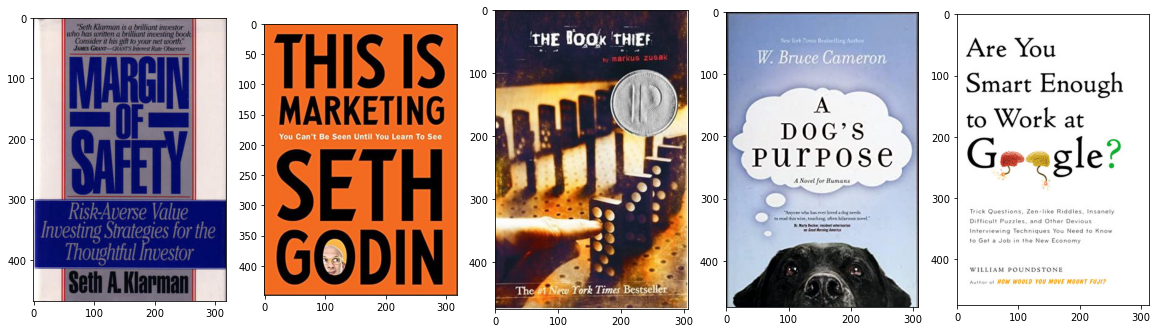

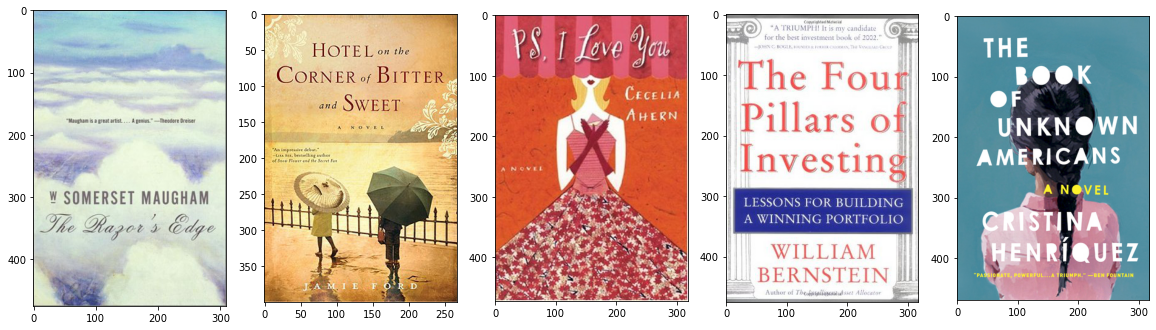

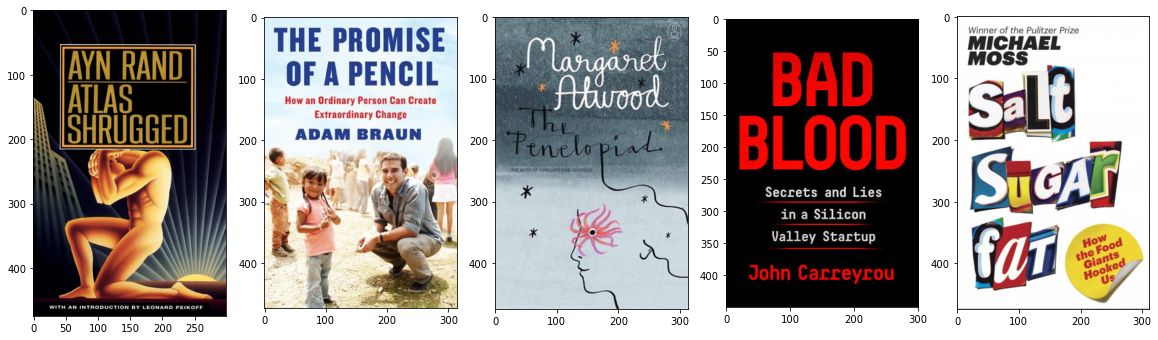

In [90]:
for _ in range(3):
    print('----------Random book recommendation start!---------')
    book_title = np.random.choice(title, 1)
    print(f'If I choose {book_title}...........')
    recommendations(book_title[0])
    print('-----------------------Done-------------------------')

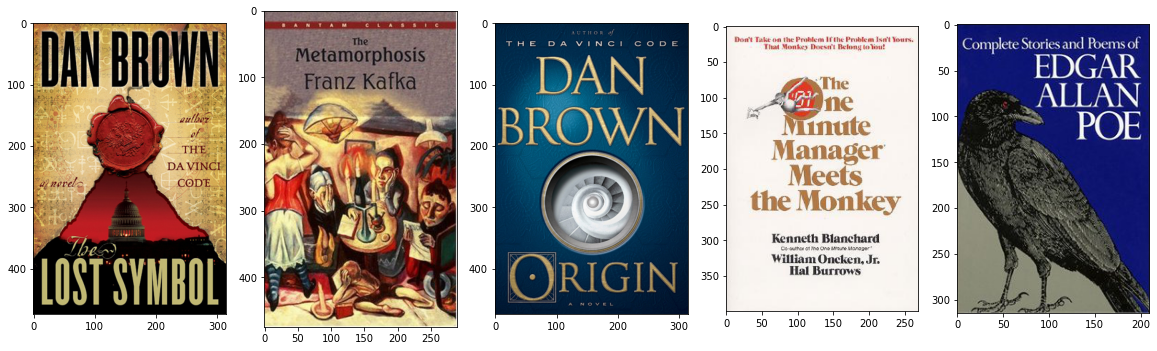

In [91]:
# test
recommendations("The Da Vinci Code")